# Cifar 10 - Image Classification on a Raspi with TFLite
by MJRovai @ 18Aug2025

## Import libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tflite_runtime.interpreter as tflite

/home/mjrovai/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import tflite_runtime as tflr
print(tflr.__version__)

2.14.0


## Paths

In [4]:
model_path = "./models/cifar10.tflite"
img_path = "./images/cat_2.jpg"

In [5]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
# Load the TFLite model
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [8]:
input_details

[{'name': 'serving_default_keras_tensor:0',
  'index': 0,
  'shape': array([ 1, 32, 32,  3], dtype=int32),
  'shape_signature': array([-1, 32, 32,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [9]:
output_details

[{'name': 'StatefulPartitionedCall_1:0',
  'index': 17,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.float32

The input dtype is 'float32'. This is because the pixels were normalized before being used in the model, having a range of [0, 1]. So, the input image also needs to be normalized.

In [11]:
# Load the image
img = Image.open(img_path)

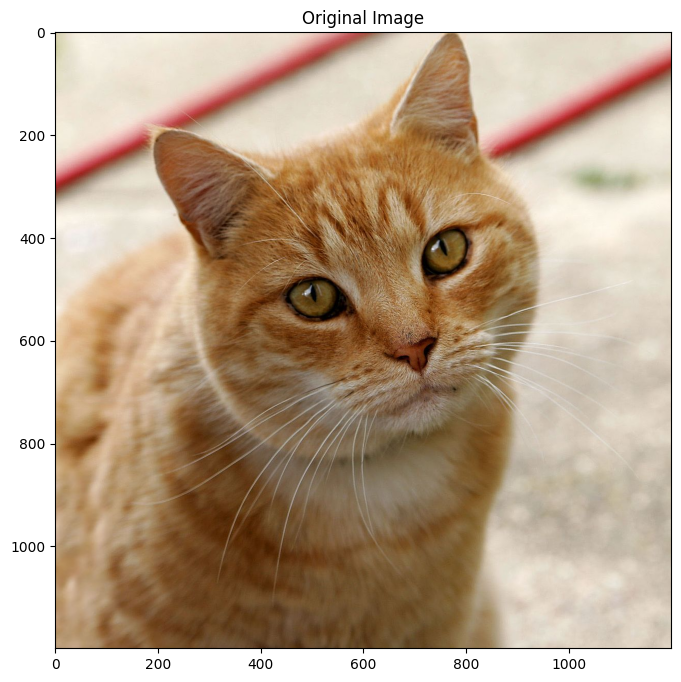

In [12]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
#plt.axis('off')  # This turns off the axis numbers
plt.title("Original Image")
plt.show()

In [13]:
width, height = img.size
channels = len(img.getbands())
shape = (height, width, channels)

print(f"Image shape: {shape}")

Image shape: (1199, 1200, 3)


In [14]:
# Preprocess the image
img = img.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))
input_data = np.expand_dims(img, axis=0)
input_data = (input_data/255.).astype(np.float32)
input_data.shape

(1, 32, 32, 3)

In [15]:
# Get dtype of the input data
input_data.dtype

dtype('float32')

Note that the dtype now is compatible. 

In [54]:
new_size = (input_details[0]['shape'][1], input_details[0]['shape'][2])
new_size

(32, 32)

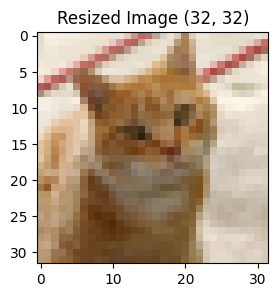

In [55]:
# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(img)
#plt.axis('off')  # This turns off the axis numbers
plt.title("Resized Image "+str(new_size))
plt.show()

In [17]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 19.2ms


In [19]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]

In [20]:
predictions

array([2.3233637e-04, 4.7528779e-06, 1.9293673e-02, 5.6233776e-01,
       2.2445317e-02, 2.4867173e-01, 1.4342956e-01, 3.5295868e-03,
       4.1741238e-05, 1.3512191e-05], dtype=float32)

In [21]:
predictions.shape

(10,)

In [22]:
# Get the index of the top result
top_index = np.argsort(predictions)[::-1][0]
top_index

3

In [23]:
print(labels[3])

cat


In [24]:
print (predictions[5])

0.24867173


### Testing with images

### Define a general Image Classification function

In [25]:
def image_classification(img_path, model_path, labels, top_k_results=5):
    # load the image
    img = Image.open(img_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    input_data = np.expand_dims(img, axis=0)
    input_data = (input_data/255.).astype(np.float32)

    # Inference on Raspi-Zero
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Obtain results and map them to the classes
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_index = np.argsort(predictions)[::-1][0]

    print("\n[PREDICTION]        [Prob]\n")
    print("{:20}: {}%".format(
    labels[top_index], (int(predictions[top_index]*100))))

In [26]:
model_path = "./models/cifar10.tflite"
img_path = "./images/cat_2.jpg"
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


[PREDICTION]        [Prob]

cat                 : 56%


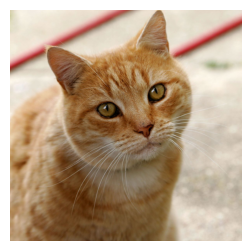

In [27]:
image_classification(img_path, model_path, labels, top_k_results=5)

In [28]:
!ls ./images

cam_img_test.jpg  car_3.jpg  Cat03.jpg	cat_2.png  dog_2.jpg  img_test.jpg
car_1.jpg	  car_4.jpg  cat_1.jpg	cup.jpg    dog_3.jpg  ship_1.jpg
car_2.jpg	  car_5.jpg  cat_2.jpg	dog_1.jpg  images     ship_2.jpg



[PREDICTION]        [Prob]

automobile          : 99%


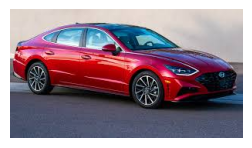

In [29]:
img_path = "./images/car_1.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

automobile          : 99%


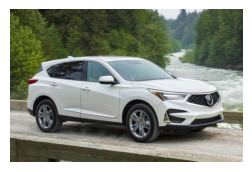

In [30]:
img_path = "./images/car_2.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

automobile          : 99%


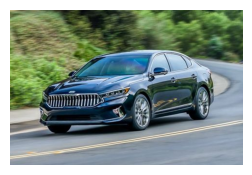

In [31]:
img_path = "./images/car_3.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

automobile          : 86%


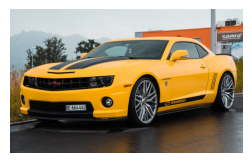

In [32]:
img_path = "./images/car_4.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

truck               : 75%


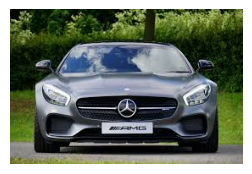

In [33]:
img_path = "./images/car_5.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

cat                 : 77%


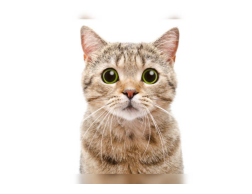

In [34]:
img_path = "./images/cat_1.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

cat                 : 56%


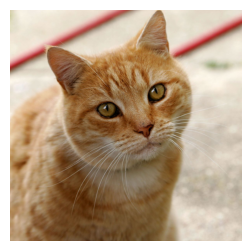

In [35]:
img_path = "./images/cat_2.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

dog                 : 44%


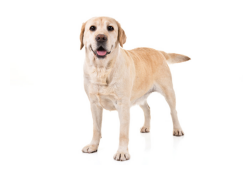

In [36]:
img_path = "./images/dog_1.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

airplane            : 54%


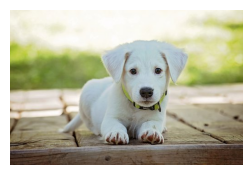

In [37]:
img_path = "./images/dog_2.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

dog                 : 84%


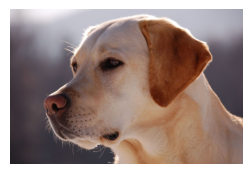

In [38]:
img_path = "./images/dog_3.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

ship                : 88%


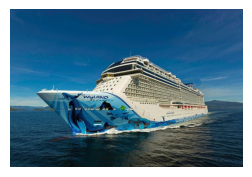

In [39]:
img_path = "./images/ship_1.jpg"
image_classification(img_path, model_path, labels)


[PREDICTION]        [Prob]

ship                : 53%


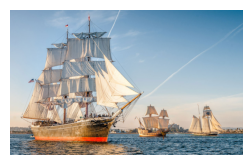

In [40]:
img_path = "./images/ship_2.jpg"
image_classification(img_path, model_path, labels)

In [4]:
ls

10_Image_Classification.ipynb  setup_test.ipynb  usb_camera_image.jpg
images/                        setup_test.py
models/                        Untitled.ipynb


## General Function to handle different types of models/inputs/outputs

In [41]:
def image_classification(img_path, model_path, labels, top_k_results=5, apply_softmax=False):
    # Load the image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    
    input_dtype = input_details[0]['dtype']
    
    if input_dtype == np.uint8:
        input_data = np.expand_dims(np.array(img), axis=0)
    elif input_dtype == np.int8:
        scale, zero_point = input_details[0]['quantization']
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
        input_data = np.expand_dims(img_array, axis=0)
    else:  # float32
        input_data = np.expand_dims(np.array(img, dtype=np.float32), axis=0) / 255.0

    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds

    # Obtain results
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    # Handle output based on type
    output_dtype = output_details[0]['dtype']
    if output_dtype in [np.int8, np.uint8]:
        # Dequantize the output
        scale, zero_point = output_details[0]['quantization']
        predictions = (predictions.astype(np.float32) - zero_point) * scale
    
    if apply_softmax:
        # Apply softmax
        exp_preds = np.exp(predictions - np.max(predictions))
        probabilities = exp_preds / np.sum(exp_preds)
    else:
        probabilities = predictions

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {:.1f}%".format(
            labels[top_k_indices[i]],
            probabilities[top_k_indices[i]] * 100))
    print ("\n\tInference time: {:.1f}ms".format(inference_time))

In [42]:
model_path = "./models/cifar10.tflite"
img_path = "./images/cat_2.jpg"
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


	[PREDICTION]        [Prob]

	cat                 : 56.2%
	dog                 : 24.9%
	frog                : 14.3%
	deer                : 2.2%
	bird                : 1.9%

	Inference time: 2.8ms


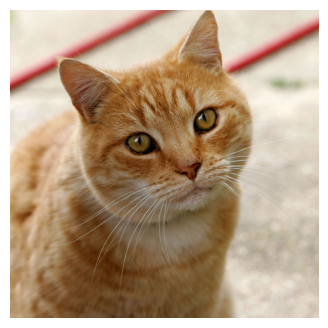

In [43]:
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	cat                 : 77.5%
	dog                 : 20.6%
	frog                : 0.7%
	ship                : 0.6%
	bird                : 0.3%

	Inference time: 2.8ms


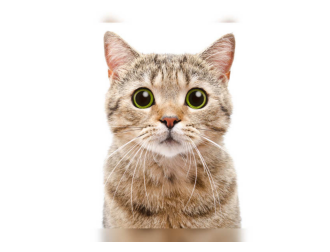

In [44]:
img_path = "./images/cat_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	automobile          : 99.7%
	truck               : 0.3%
	airplane            : 0.0%
	ship                : 0.0%
	bird                : 0.0%

	Inference time: 2.8ms


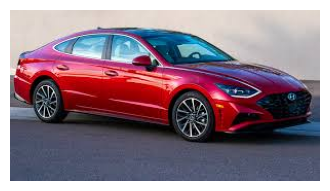

In [45]:
img_path = "./images/car_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	automobile          : 100.0%
	truck               : 0.0%
	ship                : 0.0%
	airplane            : 0.0%
	frog                : 0.0%

	Inference time: 2.8ms


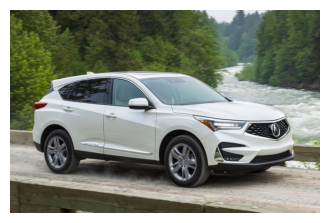

In [46]:
img_path = "./images/car_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	dog                 : 45.0%
	cat                 : 28.7%
	bird                : 9.3%
	horse               : 5.5%
	truck               : 4.2%

	Inference time: 2.7ms


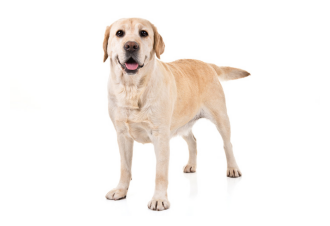

In [47]:
img_path = "./images/dog_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	ship                : 88.7%
	airplane            : 9.2%
	deer                : 1.8%
	bird                : 0.2%
	automobile          : 0.0%

	Inference time: 2.9ms


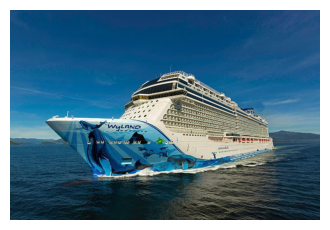

In [48]:
img_path = "./images/ship_1.jpg"
image_classification(img_path, model_path, labels)